In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, precision_recall_fscore_support
)

RANDOM_STATE = 42

df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

# Target & features
TARGET = "Diabetes_binary"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Train/validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

def evaluate(model, X_test, y_test, name="Model"):
    """Prints core metrics and returns a dict for logging/aggregation."""
    y_pred = model.predict(X_test)
    # For binary problems we can compute ROC-AUC on probabilities:
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = np.nan

    print(f"\n{name} — Classification report")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    if not np.isnan(auc):
        print(f"ROC-AUC: {auc:.4f}")

    return {
        "model": name,
        "roc_auc": auc,
        **{
            f"f1_{label}": f1
            for label, f1 in zip(
                sorted(np.unique(y_test)),
                precision_recall_fscore_support(y_test, y_pred, average=None)[2]
            )
        }
    }

In [3]:
from sklearn.svm import SVC

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=RANDOM_STATE))
])
svm_clf.fit(X_train, y_train)
svm_metrics = evaluate(svm_clf, X_test, y_test, "SVM (RBF)")



SVM (RBF) — Classification report
              precision    recall  f1-score   support

           0     0.7810    0.6945    0.7352      7070
           1     0.7249    0.8052    0.7630      7069

    accuracy                         0.7498     14139
   macro avg     0.7529    0.7498    0.7491     14139
weighted avg     0.7529    0.7498    0.7491     14139

Confusion matrix:
 [[4910 2160]
 [1377 5692]]
ROC-AUC: 0.8180


In [5]:
param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.1, 1]
}
grid_svm = GridSearchCV(svm_clf, param_grid, scoring="f1_macro", cv=3, n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
evaluate(best_svm, X_test, y_test, "SVM (Tuned)")


SVM (Tuned) — Classification report
              precision    recall  f1-score   support

           0     0.7958    0.6775    0.7319      7070
           1     0.7192    0.8261    0.7690      7069

    accuracy                         0.7518     14139
   macro avg     0.7575    0.7518    0.7504     14139
weighted avg     0.7575    0.7518    0.7504     14139

Confusion matrix:
 [[4790 2280]
 [1229 5840]]
ROC-AUC: 0.8276


{'model': 'SVM (Tuned)',
 'roc_auc': 0.8276095620798262,
 'f1_0': 0.7319122927649171,
 'f1_1': 0.768977549542432}

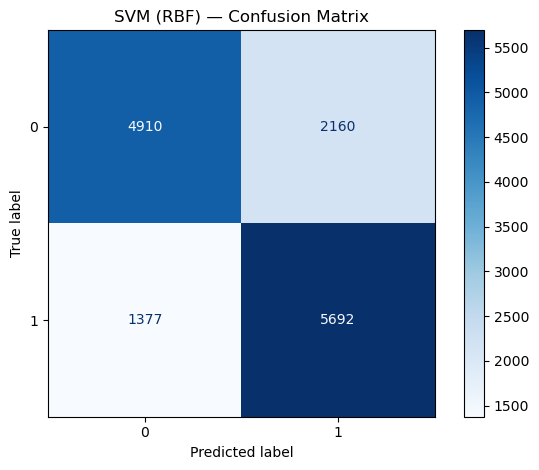

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

try:
    from sklearn.metrics import ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_estimator(svm_clf, X_test, y_test, cmap="Blues")
    plt.title("SVM (RBF) — Confusion Matrix")
    plt.tight_layout(); plt.show()
except Exception:
    # Manual fallback
    y_pred = svm_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(set(y_test)),
                yticklabels=sorted(set(y_test)))
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.title("SVM (RBF) — Confusion Matrix")
    plt.tight_layout(); plt.show()

C:\Users\Afnan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Afnan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Afnan\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Afnan\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit

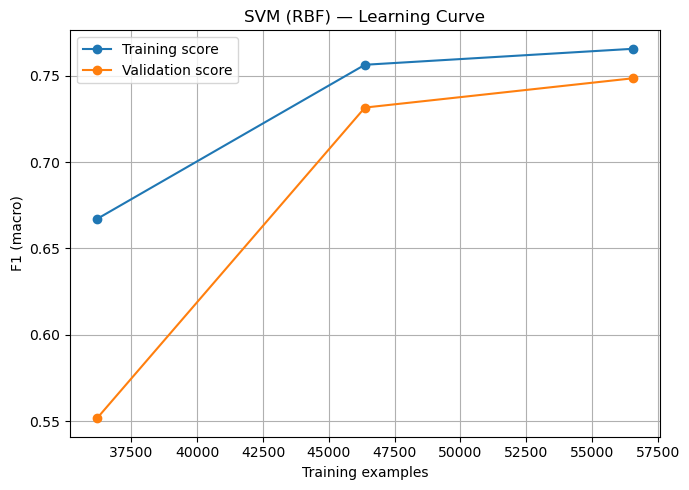

In [17]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    svm_clf, X, y, cv=5, scoring="f1_macro", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6),
    random_state=42 if hasattr(svm_clf, "random_state") else None
)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_scores.mean(axis=1), "o-", label="Training score")
plt.plot(train_sizes, val_scores.mean(axis=1), "o-", label="Validation score")
plt.title("SVM (RBF) — Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("F1 (macro)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

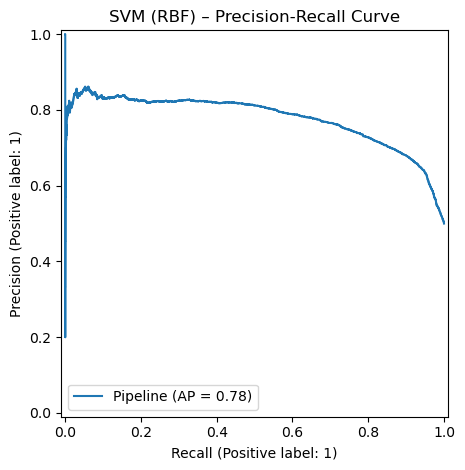

In [21]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np

if IS_BINARY:
    PrecisionRecallDisplay.from_estimator(svm_clf, X_test, y_test)
    plt.title("SVM (RBF) – Precision-Recall Curve")
    plt.tight_layout()
    plt.show()
else:
    from sklearn.preprocessing import label_binarize

    classes = np.sort(np.unique(y))
    y_bin = label_binarize(y_test, classes=classes)
    probas = svm_clf.decision_function(X_test)

    for i, class_id in enumerate(classes):
        PrecisionRecallDisplay.from_predictions(y_bin[:, i], probas[:, i], name=f"Class {class_id}")

    plt.title("SVM (RBF) – One-vs-Rest Precision-Recall")
    plt.tight_layout()
    plt.show()


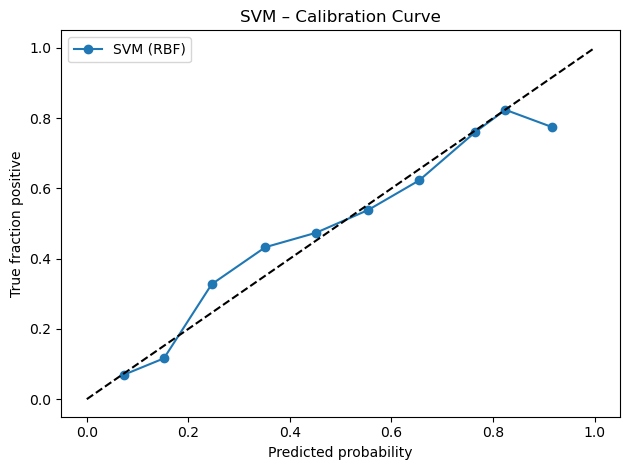

In [26]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

if IS_BINARY:
    prob_pos = svm_clf.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, prob_pos, n_bins=10)

    plt.plot(prob_pred, prob_true, "o-", label="SVM (RBF)")
    plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
    plt.title("SVM – Calibration Curve")
    plt.xlabel("Predicted probability")
    plt.ylabel("True fraction positive")
    plt.legend()
    plt.tight_layout()
    plt.show()

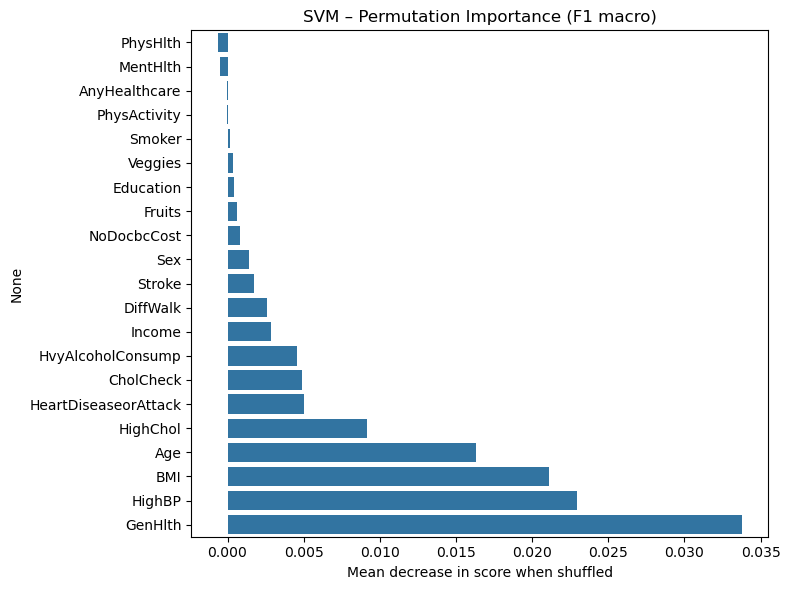

In [30]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    svm_clf, X_test, y_test,
    n_repeats=10, scoring="f1_macro", random_state=42, n_jobs=-1
)

imp = pd.Series(r.importances_mean, index=X.columns).sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(x=imp, y=imp.index)
plt.title("SVM – Permutation Importance (F1 macro)")
plt.xlabel("Mean decrease in score when shuffled")
plt.tight_layout()
plt.show()


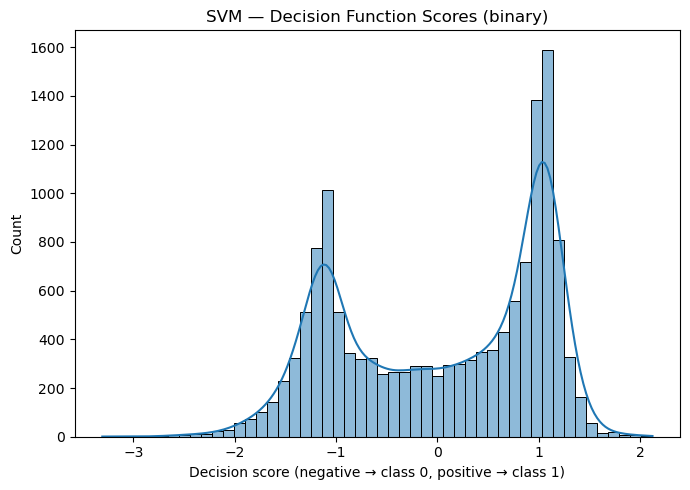

In [13]:
IS_BINARY = True !

scores = svm_clf.decision_function(X_test)

plt.figure(figsize=(7,5))
if IS_BINARY:
    sns.histplot(scores, bins=50, kde=True)
    plt.title("SVM — Decision Function Scores (binary)")
    plt.xlabel("Decision score (negative → class 0, positive → class 1)")
else:
    k = np.sort(y.unique())[-1] 
    sns.histplot(scores[:, list(np.sort(y.unique())).tolist().index(k)], bins=50, kde=True)
    plt.title(f"SVM — Decision Scores for Class {k}")
    plt.xlabel("Decision score")

plt.tight_layout(); plt.show()
